# Lecture 7 - Part 1
## Ensemble Learning and Random Forests

The idea underlying to these techniques is very simple, yet strong. It derives from the 
notion of *wisdom of crowd*, that is, if you ask a complex question to thousand of random people
and then aggregate their answers, it increases the likelihood of obtaining the right answer.

In machine learning this approach is called *Ensamble Learning*, while a learning algorithm is called
*ensemble method*.

**Example**
You can imagine to train a group od Decision TRee classifier, each one of a different random subset
of the original training set. Once the training is done, tou can predict the class of a sample
by simplying asking to each decision tree in the ensemble and then predict the class that received
more votes.

### Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Voting classifiers
Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1).

![img/voting.png](img/voting.png)

Once you have all these predictors trained and working you can aggregate their individual results according to two main
strategies:

1. *Hard Voting* - You select the class that received most votes
2. *Soft Voting* - You compute a sort of a weighted max

**Why does this approach work?**
Suppose you have a biased coin. With 51% of probability of coming up head.

If you toss it 1000 time you will have that approximately 75% of the times
the coin came up head.

If you toss it 10000 time you will see that the probability of seeing 
head get closer and closer to its actual value, i.e., 51%.


In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


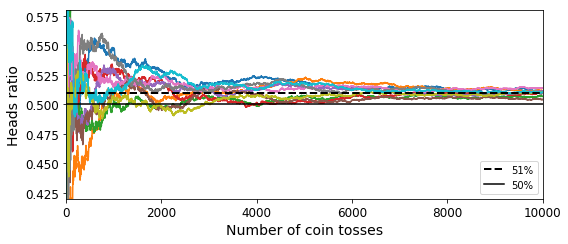

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

However, in order to obtain this boost in performance you must guarantee the perfect independency between 
each classifier, which is clearly non the case with the classic ensamble learning algorithms, since each 
weak classifier share the training set with the others.

**TIP**

Ensample methods work best when the predictors are as independent as possible.

On way to get this independency from one another is by choosing very different algorithms. This increase the chance
of having uncorrelated errors, leading an improve in the ensemple accuracy.

---

Voting classifier in sklearn


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, you need to import the classifiers you want to include in you ensamble.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# your code here
# instantiate the objects
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# insert each estimator in the ensamble
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

To convince yourself about the advantage of adopting this strategy 
you can compute the accuracy score over the test set for each learner, including the ensamble itself.

In [7]:
# your code here
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.904


__Exercise__

Execute the same test as above, this time with soft voting (you need to set the ``voting`` argument to ``"soft"``)

If all the classifiers in the ensamble estimate class probabilities (the have the ``predict_proba()`` method) you can
adopt a soft-voting strategy. 

All you need to do is to replace ``voting=hard`` to ``voting=soft``.

**Try it yourself**
Note that the ``SVC`` classifier does not compute probabilities by default. But, if you set
the argument ``probabilities=True`` it will perfors a cross validation test during training to estimate the class probabilities.

Soft voting:

In [8]:
from sklearn.metrics import accuracy_score
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.912


## Bagging and Pasting
One way to decrease the correlation between classifiers is by using different training algorithms (as discussed above) or 
by using different training set.

These techniques use the second approach. Essentially they keep the same algorithm (the same object instantiated several times)
and perform the training stage with respect to different training set.

One way of implementing this idea is by sampling a subset of samples from the training set and then give it to 
each *learner*. As a result you will have the sample algorithm applied to different subset of the original training set.

On the basis of the sampling strtaegy we can devise two scarios:

1. Bagging - short for bootstrap aggregating. The sampling is per performed **with replacement**
2. Pasting - the sampling is performend **without replacement**.


In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.


![img/bagging.png](img/bagging.png)

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. 

The aggregation function is typically the statistical mode:

1. most frequent prediciton (like hard votin) for classification tasks
2. average for regression tasks.


It should be noted that, despite Each individual predictor has a higher bias than if it were trained on the original training set, the 
aggregation reduces both bias and variance.

Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

### Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression). 

The following code trains an ensemble of 500 Decision Tree classifiers,
each trained on 100 training instances randomly sampled from the training set with replacement 
(this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False). 

The ``n_jobs`` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores):

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print("Ensamble accuracy: ",accuracy_score(y_test, y_pred))

Ensamble accuracy:  0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Single learner accuracy", accuracy_score(y_test, y_pred_tree))

Single learner accuracy 0.856


In order to visualize the differences between the two approaces you can plot the decision boundaries of each
one of them.

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


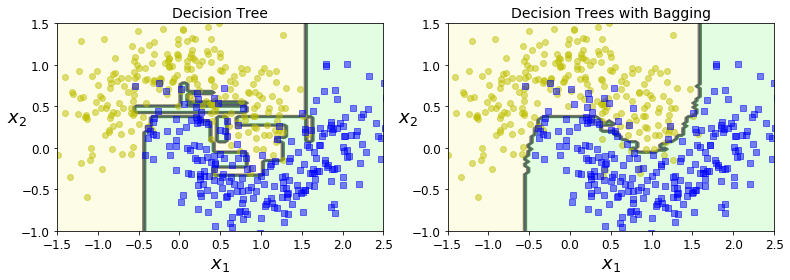

In [13]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

As you can see, 
the ensamble exhibit smoother boundaries, as a consequence
the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions.

As we have discussed above, the ensemble has a comparable bias but a smaller variance, 
this means that it makes roughly the same number of errors on the training set, but the decision boundary is less irregular.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced.


Overall, bagging often results in better models, which explains why it is generally preferred.

### Out-of-Bag Evalutaion

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 

By default a ``BaggingClassifier`` samples ``m`` training instances with replacement (``bootstrap=True``), where ``m`` is the size of the training set. 

This means that there is a cinsiderable amount of instances that are not sampled for training. 
These instances are called out-of-bag (oob) instances.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, 
without the need for a separate validation set. 
You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable:


In [14]:
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(), 
                n_estimators=500,
                bootstrap=True, 
                n_jobs=-1,
                oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

The oob score roughly resemble the error on the test set

In [15]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)


0.912

### Random Patches and Random Subspaces

The ``BaggingClassifier`` class supports sampling the features as well. 

This is controlled by two hyperparameters: ``max_features`` and ``bootstrap_features``. They work the same way as ``max_samples`` and ``bootstrap``, but for feature sampling instead of instance sampling. 

Thus, each predictor will be trained on a random subset of the input features.

This is particularly useful when you are dealing with high-dimensional inputs (such as images). 

Sampling both training instances and features is called the **Random Patches** method.

Keeping all training instances (i.e., ``bootstrap=False`` and ``max_samples=1.0``) but sampling features (i.e., ``bootstrap_features=True`` and/or ``max_features`` smaller than 1.0) is called the **Random Subspaces** method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

__Exercise__ Try a bagging classifier with random patches.

In [20]:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=1, bootstrap_features=True, bootstrap=False,  random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)
print(X_test.shape)

(125, 2)


## Random Forests

As we have discussed, a Random Forest is an ensemble of Decision Trees.

It is generally trained via the baggin method (thus it bootstraps, i.e., sampling with replacement).

With the argument ``max_samples`` you set the maximum number od point in each training set.

It is worth noting that a RandomForestClassifer can also be implemented via the BaggingClassifier, however it is preferable to use
directly the RandomForestClassifier as it is optimized for working with decision trees.

Similarly, there is a RandomForestRegressor class for regression tasks.

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a 
BaggingClassifier to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node
it searches for the best feature among a random subset of features. 

This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:

**Exercise**
Implement a random forest classifier by using the baggin classifier you have seen earlier.

You must set  a decision tree classifier as the basic learner of the BaggingClassifier object.

Also, the Bagging Classifier should contains 500 trees.

In [26]:
# your code here

# implement it via the BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [27]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [28]:
# accuracy 
y_pred = bag_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

**Feature Importance**

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. 

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). 

More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. 

You can access the result using the ``feature_importances_`` variable. 

For example, the following code trains a RandomForestClassifier on the iris dataset and outputs each feature’s importance. 

It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [30]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

The following code trains 15 ``DecisionTreeClassifier``, each one of them ios given with a different portion of the training set.

After every learning episode the decision boundaries are plotted.

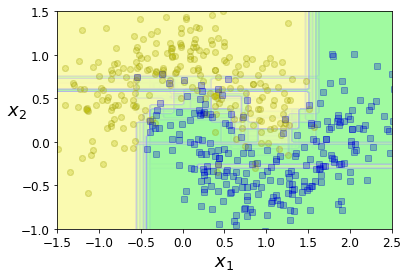

In [31]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**Conlcusion**
Random Forests are very handy to get a quick understanding of what features actually matter.

Intuitevely one should consider the option of using a random forest in order to extract the features that are important the most.

---
## Boosting
Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

There are many boosting methods available, but by far the most popular are AdaBoost13 (short for Adaptive Boosting) and Gradient Boosting. Let’s start with AdaBoost.

### AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on (see Figure 7-7).

This leads to a sequence of training phase as shown in the following figure:

![img/adaboost.png](img/adaboost.png)

**Question**
There is a major drawback with this technique. Any idea?

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.





In [32]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

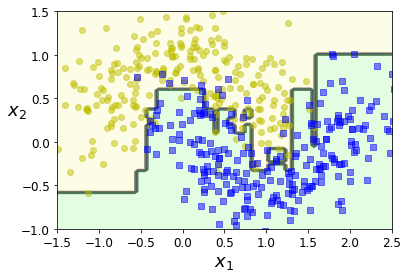

In [33]:
plot_decision_boundary(ada_clf, X, y)


The decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel14). The first classifier gets many instances wrong, so their weights get boosted. 

The second classifier therefore does a better job on these instances, and so on.

The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). 

As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, 
AdaBoost adds predictors to the ensemble, gradually making it better.

Saving figure boosting_plot


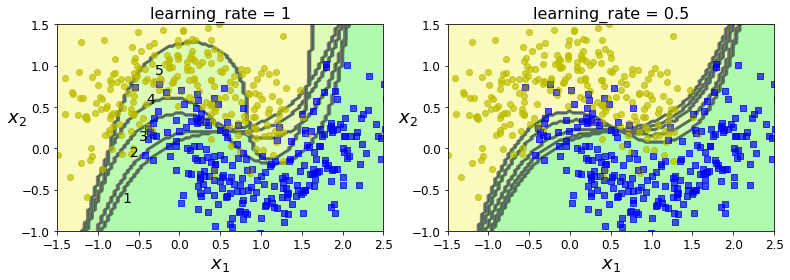

In [34]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

Here is the list of the internal variables of AdaBoost.

In [35]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

It should be noted that AdaBoost behaves like if it adds one estimator at each consecutive time-step. 

However, if the learning stage is different from the one adopted in the aforementioned strategies, the prediction stage remains the same.

In paticular, prediciton are made by the means of a soft-voting strategy, where the vote of each classifier is weighted according to its accuracy.

**Let's take a closer look**
At the very beginning of the algorithm, each data point in the training set $\mathcal{D}$ is given with the same weight, let's say $w^{(i)} = \frac{1}{m}$ for 
every $x^{(i)} \in \mathcal{D}$ (m is the size of the training set).

After the first training episode, a weighted error is computed for each data poin the training set. 

This weighted error rate of the j-th predictor is is given by:

$$
r_j = \frac{\sum_{\forall i  \text{ s.t. } \hat{y^{(i)}} \neq y^{(i)} }^{m} w^{(i)}}{\sum_{i=1}^m w^{(i)}}
$$

It is is basically the sum of the weights for all the instances that are misclassified by the j-th predictor over
the sum of all the weights associated with each point in the data set.

The predictor’s weight $\alpha_j$ is then computed using the following equation:

$$
\alpha_j = \eta \log \frac{1-r_j}{r_j}
$$

where $\eta$ is the learning rate hyperparameter (defaults to 1).

The more accurate the predictor is, the higher its weight will be. 

If it is just guessing randomly, then its weight will be close to zero.
However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

Next, for the succesive training episode, the weights of each training sample are recomputed according to the following equation:

$$
w^{(i)} = \left\{ \begin{array}{ll}
                    w^{(i)} & \text{if } \hat{y^{(i)}} = y^{(i)} \\
                    w^{(i)}  e^{\alpha_j} & \text{otherwise}
                  \end{array}\right.
$$

Before starting the following training all weights are normalized (i.e., divided by $\sum_{i=1}^{m} w^{(i)}$)

This process is repeated iteratively until either the predefined number of predictors is reached or the perfect predictor is found.

Finally teh prediction is made according to the following equation:

$$
\hat{y}(x) = arg\max_{k} \sum_{j=1 \\ \hat{y_j}(x) = k}^{N} \alpha_j
$$

It is the class that received most votes (weighted by the $\alpha$ score of the predictors.

Where $N$ is the number of predictors.

# Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting. 

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. 

However, instead of tweaking the instance weights at every iteration like AdaBoost does, 
this method tries to fit the new predictor to the residual errors made by the previous predictor.

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). 

This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT).
First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

In [36]:
from sklearn.tree import DecisionTreeRegressor
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
np.random.seed(42)

# train the first predictor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# compute the residual and train the second predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# compute the residual and train the third predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees.

In [39]:
# prediction
X_new = np.array([[0.8]])
y_new = 3*X_new**2 + 0.05 * np.random.randn(1)
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

The followinf figures represents the predictions of these three trees in the left column,
vs the ensemble’s predictions in the right column. 

In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. 

In the second row, a new tree is trained on the residual errors of the first tree. 
On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. 


Similarly, in the third row another tree is trained on the residual errors of the second tree.


You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**Question: why fitting the residuals?**

Saving figure gradient_boosting_plot


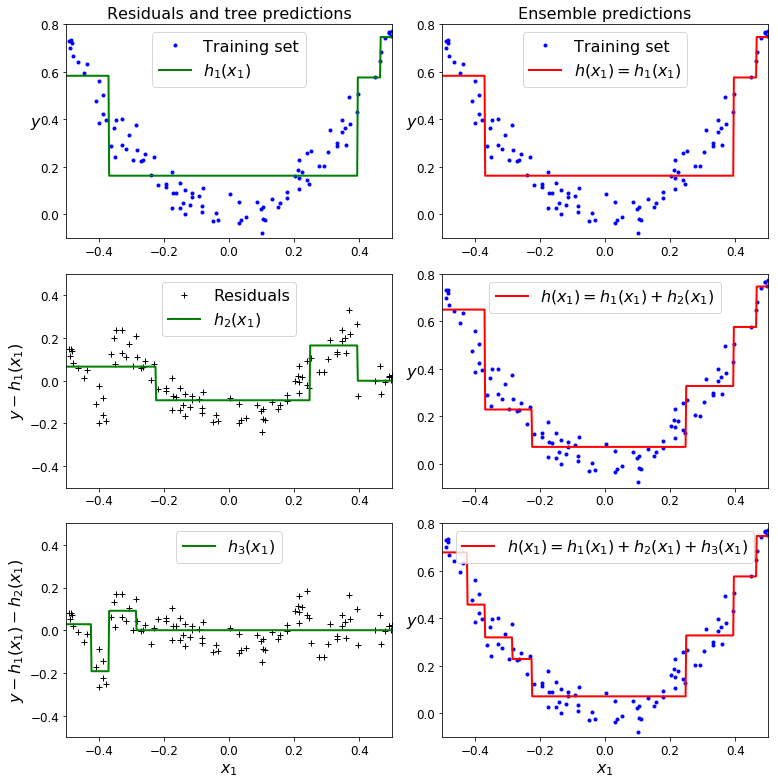

In [38]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Of course sklearn provides a class for this kind of ensamble.

One important parameter is the  ``learning_rate``.

Hhyperparameter scales the contribution of each tree.
If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set,
but the predictions will usually generalize better. 

This is a regularization technique called shrinkage. 



In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Figure shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

Saving figure gbrt_learning_rate_plot


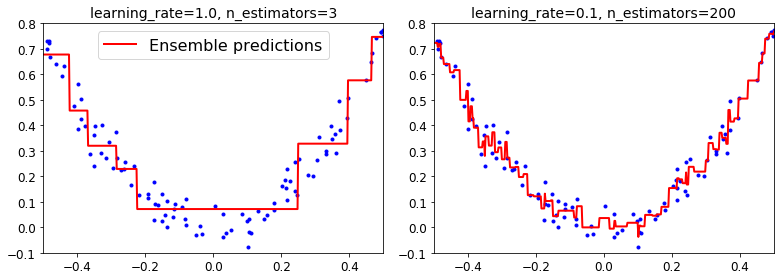

In [42]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In order to find the optimal number of trees, you can use early stopping.

You can implement an early stopping strategy according with two approaches
A simple way to implement this is to use the ``staged_predict()`` method:
it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.).

The following code trains a GBRT ensemble with 120 trees, 
then measures the validation error at each stage of training 
to find the optimal number of trees, and finally trains another 
GBRT ensemble using the optimal number of trees:

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# use staged_predict for getting a sequence of predictions
# !!!!!!!!! THE EVALUATION MUST BE DONE OUT-SAMPLE (ON THE VALIDATION SET) !!!!!!!!!!!
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# get the number of tree corresponding to the minimum error
bst_n_estimators = np.argmin(errors)

# re-train the regressor
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)
print(bst_n_estimators)

39


**Question** - What happen if we evaluate the performance of the BoostingRegressor upon the training set?

In [46]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


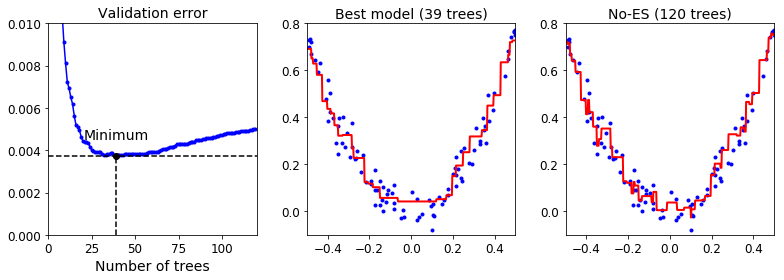

In [48]:
plt.figure(figsize=(11, 4))

plt.subplot(131)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(132)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)



##########################################
# Question: What kind of result do you expect
# to have from the model with 120 estimators?
#
plt.subplot(133)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("No-ES (%d trees)" % 120, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

Instead of doing a full training stage and then looking back at the performance obtained along the way (from 1 estimator to ``n_estimators``)
you can perform early stopping directly during the training stage.

You must set ``warm_start=True``, which makes sklearn keep existing trees when the ``fit()`` method is called, allowing incremental training.

The following code stop training then the validation error does not improve for five iterationin a row.

In [50]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [51]:
print(gbrt.n_estimators)

38


In [52]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.0037568531951897876


GradientBoosting provide also an additional option, called ``subsample``. 

For instance, when ``subsample=.25``, it means that each tree in the ensamble is trained against
the  25% of the entire training set. 

Of course, in this way you are reducing variance at the cost of a higher bias. 

This technique is often referred as **Stochastic Gradient Boosting**. It is generally faster than the previous solutions.



### Using XGBoost
It is an optimized implementation of gradient boosting.



In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

In [ ]:
if xgboost is not None: 
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

It does not guarantee a boost in performance in terms of effectiveness, but it does provide a boost in performance in terms of efficiency.

## 9. Stacking Ensemble
The last ensamble method we will discuss is called stacking (short for stacked generalization).

It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation? 

Figure shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0).

![img/stacking1.png](img/stacking1.png)


To train the *blender*, a common approach is to use a hold-out set. 

---

Let’s see how it works. First, the training set is split in two subsets. 

> **The first subset**. 
    The first subset is used to train the predictors in the first layer (see Figure 7-13).
    Next, the first layer predictors are used to make predictions on the second (held-out) set (see Figure 7-14). This
    ensures that the predictions are “clean,” since the predictors never saw these instances during training.

![img/stacking2.png](img/stacking2.png)

> **The second subset**. It is created starting from the predictions made by the estimators trained wrt the first subset of training samples.
 Now for each instance in the hold-out set there are three predicted values. We can create     a new training set using these predicted values as input features (which makes this new training set 
 three-dimensional), and keeping the target values. The blender is trained on this new training 
 set, so it learns to predict the target value given the first layer’s predictions.


![img/stacking3.png](img/stacking3.png)


It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially, as shown in Figure 7-15.


Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your own implementation.


---
# Exercises

## Exercise 1

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_val, y_val)

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [ ]:
voting_clf.set_params(svm_clf=None)

This updated the list of estimators:

In [ ]:
voting_clf.estimators

However, it did not update the list of _trained_ estimators:

In [ ]:
voting_clf.estimators_

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [ ]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [ ]:
voting_clf.score(X_val, y_val)

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

That's a significant improvement, and it's much better than each of the individual classifiers.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [ ]:
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

The voting classifier reduced the error rate from about 4.0% for our best model (the `MLPClassifier`) to just 3.1%. That's about 22.5% less errors, not bad!



# Exercise 2
Exercise: Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

In [ ]:
rnd_forest_blender.oob_score_

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred) 